In [85]:
print("Python běží!")

Python běží!


In [86]:
import sys
!{sys.executable} -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


## Rozpoznání auta
obrázek cv01_auto.jpg 

úkol: detekujte auto, zjistěte barvu, rozpoznejte SPZ.

In [87]:
import cv2
import easyocr
import webcolors
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

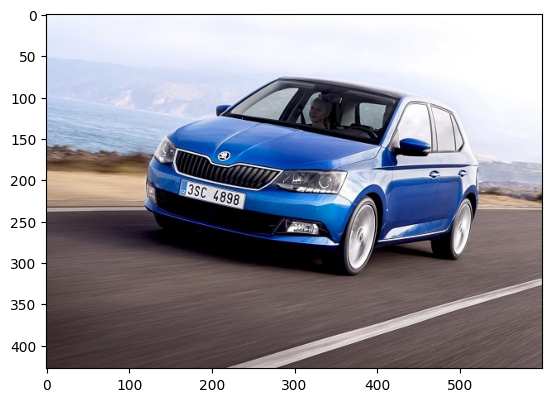

In [88]:
# Zobrazení auta
img_file = "cv01_auto.jpg"
img = cv2.imread(img_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

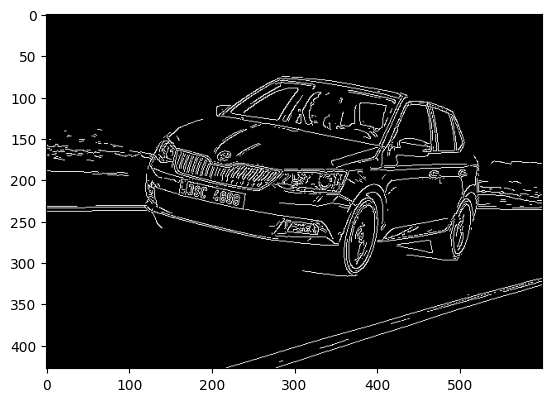

In [89]:
# detekce hran v obraze
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
edges = cv2.Canny(gray, 150, 200)
plt.imshow(edges, cmap='gray')

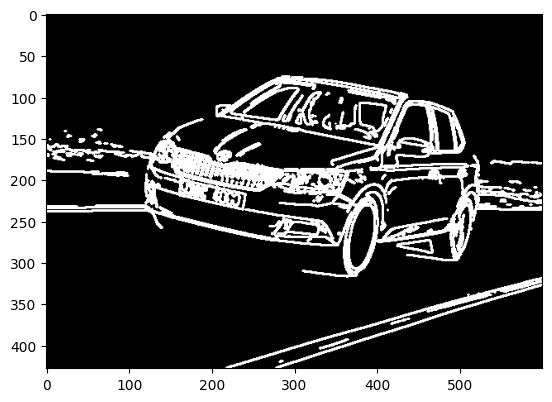

In [137]:
# detekce obrysů
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.zeros_like(img)
cv2.drawContours(img_contours, contours, -1, (255, 255, 255), 2)

plt.imshow(img_contours)

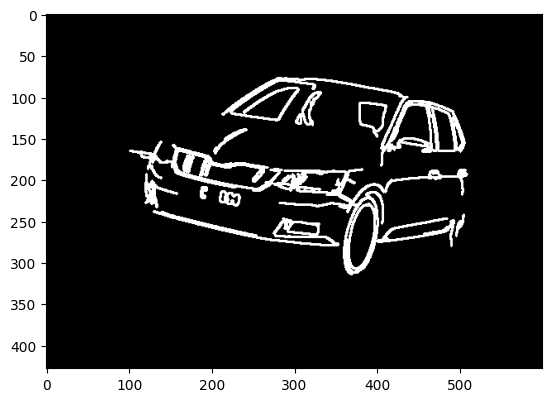

In [91]:
# Odstraneni malych oblasti
sensitivity = 20
img_contours = np.zeros_like(img)
for contour in contours:
    if cv2.contourArea(contour) > sensitivity:
        cv2.drawContours(img_contours, [contour], -1, (255, 255, 255), 2)

plt.imshow(img_contours)

In [92]:
# konverze na binarni obraz
img_contours = cv2.cvtColor(img_contours, cv2.COLOR_RGB2GRAY)
_, img_contours = cv2.threshold(img_contours, 127, 255, cv2.THRESH_BINARY)

In [93]:
print(np.shape(img_contours))

# max a min souradnice v osach x a y
x_min = np.min(np.where(img_contours > 0)[1])
x_max = np.max(np.where(img_contours > 0)[1])
y_min = np.min(np.where(img_contours > 0)[0])
y_max = np.max(np.where(img_contours > 0)[0])
print((x_min, x_max), (y_min, y_max))


(428, 600)
(np.int64(100), np.int64(510)) (np.int64(76), np.int64(315))


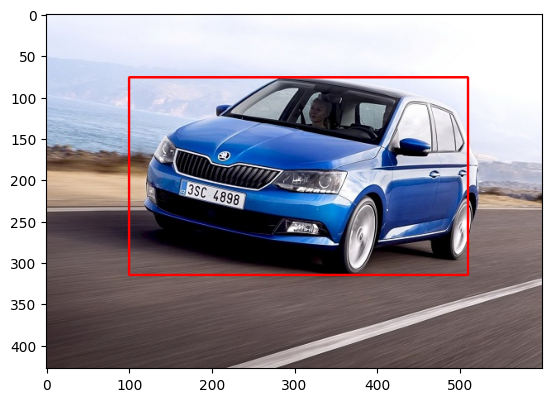

In [94]:
# obdelnik kolem auta
img_rect = img.copy()
cv2.rectangle(img_rect, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
plt.imshow(img_rect)

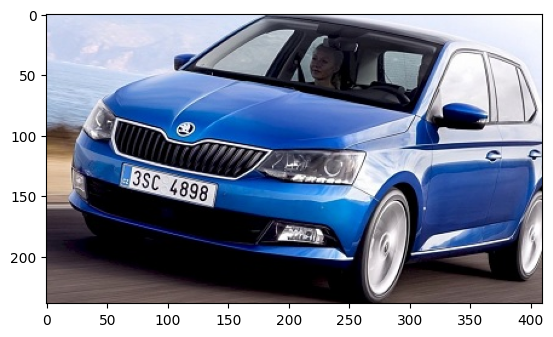

In [12]:
# Vyrez auta
img_car = img[y_min:y_max, x_min:x_max]
plt.imshow(img_car)

### Detekce převládající barvy

In [95]:
def get_dominant_colors(pil_img, palette_size=16, num_colors=10):
    # Resize image to speed up processing
    img = pil_img.copy()
    img.thumbnail((100, 100))

    # Reduce colors (uses k-means internally)
    paletted = img.convert('P', palette=Image.ADAPTIVE, colors=palette_size)

    # Find the color that occurs most often
    palette = paletted.getpalette()
    color_counts = sorted(paletted.getcolors(), reverse=True)

    dominant_colors = []
    for i in range(num_colors):
      palette_index = color_counts[i][1]
      dominant_colors.append(palette[palette_index*3:palette_index*3+3])

    return dominant_colors

In [96]:
dominant_colors = get_dominant_colors(Image.fromarray(img_car))
print(dominant_colors)

[[22, 80, 164], [0, 0, 0], [219, 223, 239], [91, 86, 99], [160, 169, 192], [30, 30, 48], [239, 241, 249], [136, 139, 154], [69, 62, 70], [14, 13, 28]]


In [97]:
def closest_colour(requested_colour):
    min_colours = {}
    for name in webcolors.names("css3"):
        r_c, g_c, b_c = webcolors.name_to_rgb(name)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def rgb_to_color_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
        actual_name = None
    return actual_name, closest_name

# Příklad použití
print(dominant_colors[0])
rgb_tuple = dominant_colors[0]
color_name = rgb_to_color_name(rgb_tuple)
print(color_name)

[22, 80, 164]
(None, 'darkslateblue')


### Rozpoznání SPZ

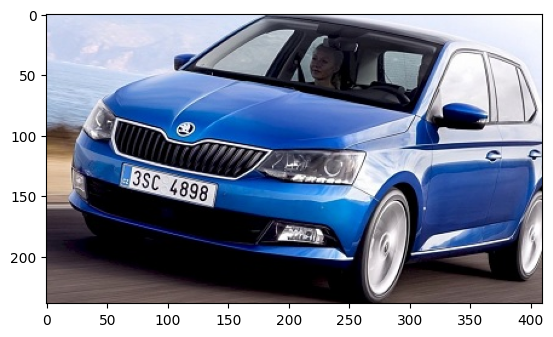

In [98]:
# auto
plt.imshow(img_car)

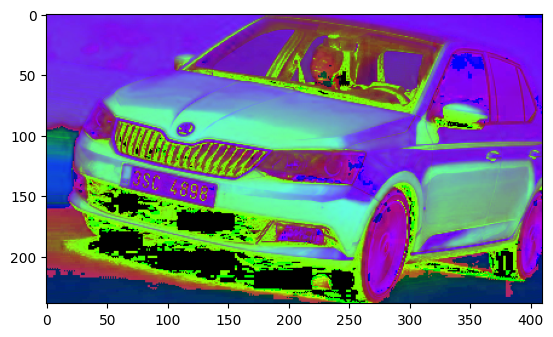

In [99]:
# vyrez SPZ

# Konverze do HSV
# Převod obrázku z BGR do HSV
hsv_image = cv2.cvtColor(img_car, cv2.COLOR_RGB2HSV)

plt.imshow(hsv_image)

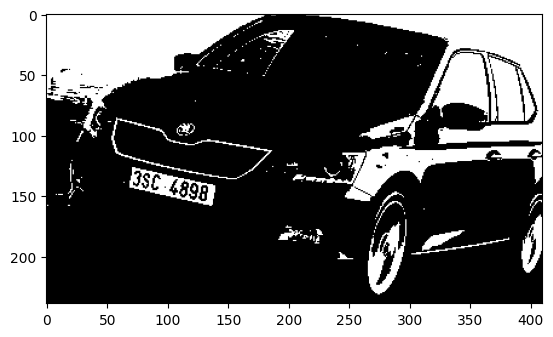

In [100]:
# detekce bileho obdelniku

# HSV, prevod do bile
img_white = cv2.inRange(hsv_image, (0, 0, 200), (180, 50, 255))
plt.imshow(img_white, cmap='gray')

In [101]:
# predpokladam ze auto jede do leva a neni na strese
y_min = 100
y_max = 200
x_min = 0
x_max = 200

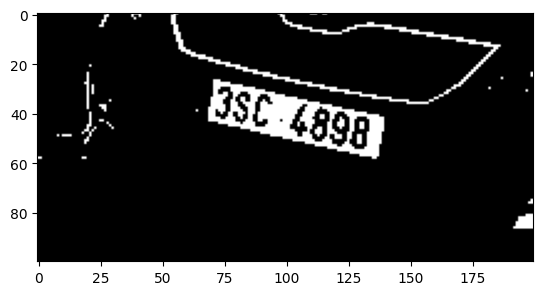

In [102]:
crop_car_front = img_white[y_min:y_max, x_min:x_max]
plt.imshow(crop_car_front, cmap='gray')

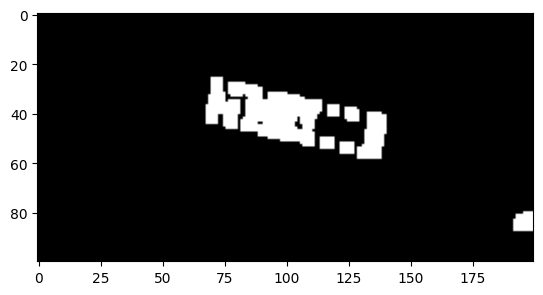

In [103]:
# eroze a dilatace
crop_car_front_erosion = crop_car_front

kernel = np.ones((3, 3), np.uint8)
crop_car_front_erosion = cv2.erode(crop_car_front_erosion, kernel, iterations=1)

kernel = np.ones((5, 5), np.uint8)
crop_car_front_erosion = cv2.dilate(crop_car_front_erosion, kernel, iterations=1)
#crop_car_front_erosion = cv2.erode(crop_car_front_erosion, kernel, iterations=1)
plt.imshow(crop_car_front_erosion, cmap='gray')


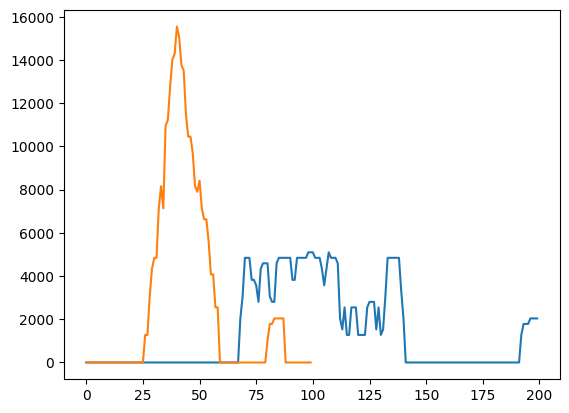

In [105]:
# zastoupeni bilych pixelu v ose x
axis_x = np.sum(crop_car_front_erosion, axis=0)

# zastoupeni bilych pixelu v ose y
axis_y = np.sum(crop_car_front_erosion, axis=1)

# jako graf x a y
plt.plot(axis_x)
plt.plot(axis_y)

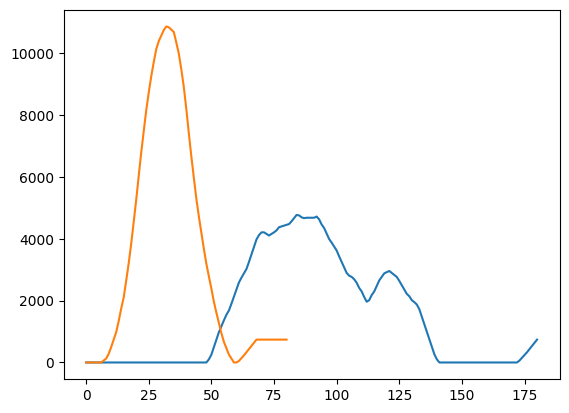

In [106]:
# klouzavý průměr
window_size = 20

axis_x_smooth = np.convolve(axis_x, np.ones(window_size)/window_size, mode='valid')
axis_y_smooth = np.convolve(axis_y, np.ones(window_size)/window_size, mode='valid')

plt.plot(axis_x_smooth)
plt.plot(axis_y_smooth)

55 136
13 54


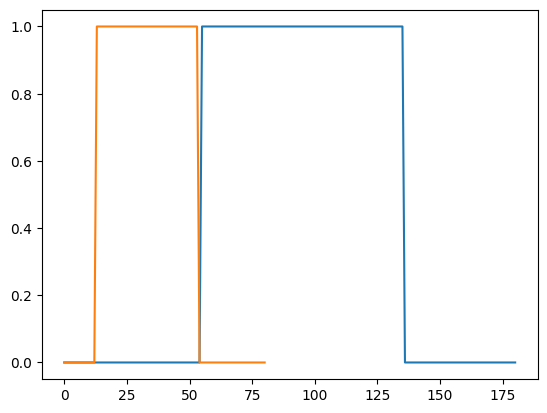

In [107]:
# prahovani
threshold_x = 1200
threshold_y = 1200

axis_x_thresholded = axis_x_smooth > threshold_x
axis_y_thresholded = axis_y_smooth > threshold_y

# zobrazeni
plt.plot(axis_x_thresholded)
plt.plot(axis_y_thresholded)

# začátek a konec SPZ
start_x = np.argmax(axis_x_thresholded)
end_x = len(axis_x_thresholded) - np.argmax(axis_x_thresholded[::-1])

start_y = np.argmax(axis_y_thresholded)
end_y = len(axis_y_thresholded) - np.argmax(axis_y_thresholded[::-1])

print(start_x, end_x)
print(start_y, end_y)

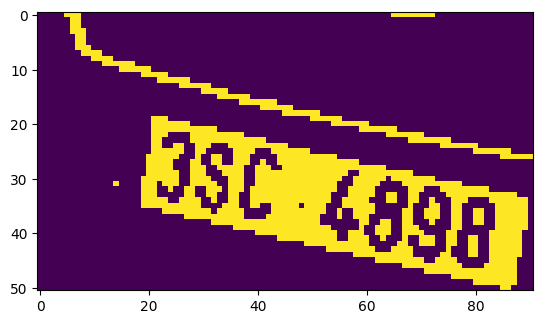

In [108]:
# vyrez SPZ
offset = 5
crop_spz = crop_car_front[start_y-offset:end_y+offset, start_x-offset:end_x+offset]
plt.imshow(crop_spz)

77.47119140625
12.52880859375


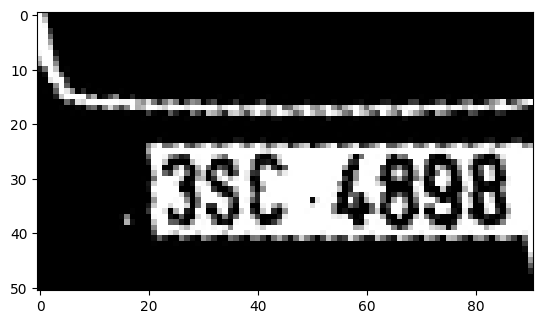

In [109]:
# Load image, grayscale, Otsu's threshold
image = crop_spz

# Compute rotated bounding box
coords = np.column_stack(np.where(image > 0))
angle = cv2.minAreaRect(coords)[-1]

print(angle)
if angle < -45:
    angle = -(90 + angle)
else:
    angle = -angle
    
angle += 90
print(angle)

# Rotate image to deskew
(h, w) = image.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

plt.imshow(rotated, cmap='gray')

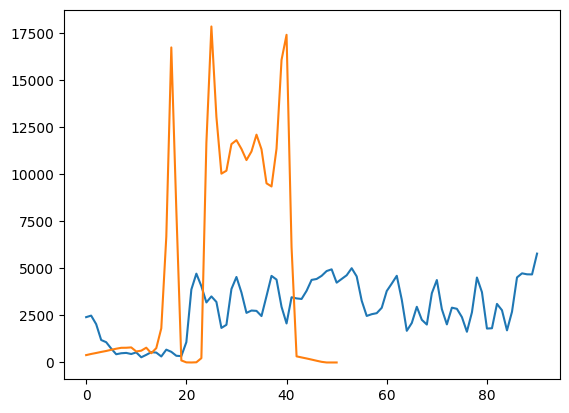

In [110]:
# Crop image
image = rotated
# zastoupeni bilych pixelu v ose x
axis_x = np.sum(image, axis=0)

# zastoupeni bilych pixelu v ose y
axis_y = np.sum(image, axis=1)


# jako graf x a y
plt.plot(axis_x)
plt.plot(axis_y)

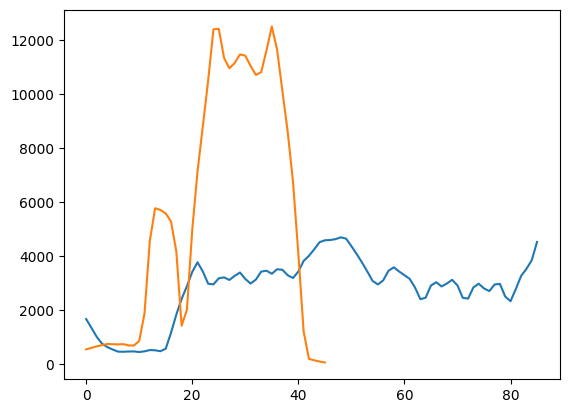

In [111]:
# klouzavý průměr
window_size = 6

axis_x_smooth = np.convolve(axis_x, np.ones(window_size)/window_size, mode='valid')
axis_y_smooth = np.convolve(axis_y, np.ones(window_size)/window_size, mode='valid')

plt.plot(axis_x_smooth)
plt.plot(axis_y_smooth)

18 86
21 40


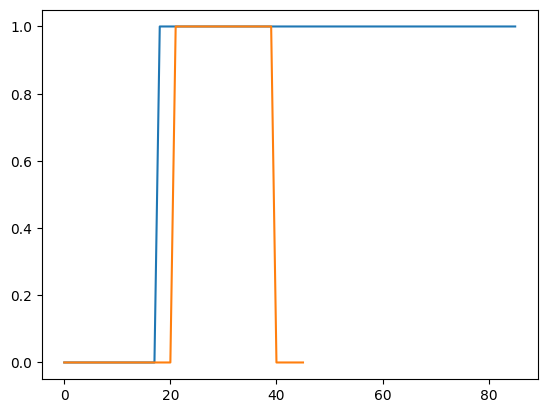

In [112]:
# prahovani
threshold_x = 2000
threshold_y = 6000

axis_x_thresholded = axis_x_smooth > threshold_x
axis_y_thresholded = axis_y_smooth > threshold_y

# zobrazeni
plt.plot(axis_x_thresholded)
plt.plot(axis_y_thresholded)

# začátek a konec SPZ
start_x = np.argmax(axis_x_thresholded)
end_x = len(axis_x_thresholded) - np.argmax(axis_x_thresholded[::-1])

start_y = np.argmax(axis_y_thresholded)
end_y = len(axis_y_thresholded) - np.argmax(axis_y_thresholded[::-1])

print(start_x, end_x)
print(start_y, end_y)

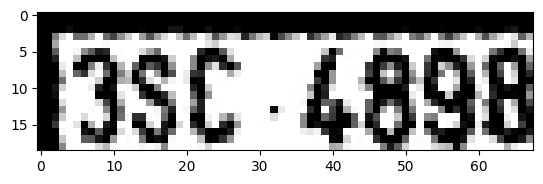

In [113]:
# vyrez SPZ
offset = 0
crop_rotated_spz = rotated[start_y-offset:end_y+offset, start_x-offset:end_x+offset]
plt.imshow(crop_rotated_spz, cmap='gray')

In [122]:
# download model
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/home/pytel/.local/lib/python3.12/site-packages/easyocr/detection.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(copyStateDict(torch.load(trained_m

Text: 3SC . 4898, Probability: 0.4099023952676467


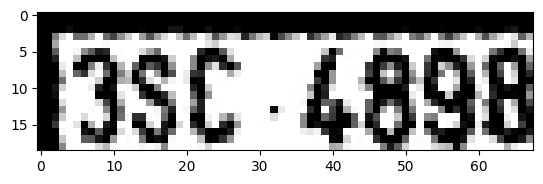

In [125]:
# Konverze do černobílého obrázku
spz_bw = crop_rotated_spz
plt.imshow(spz_bw, cmap='gray')

# read text
result = reader.readtext(spz_bw)

for (bbox, text, prob) in result:
    print(f'Text: {text}, Probability: {prob}')

## Shrnutí

Barvy auta: darkslateblue
SPZ: 3SC . 4898


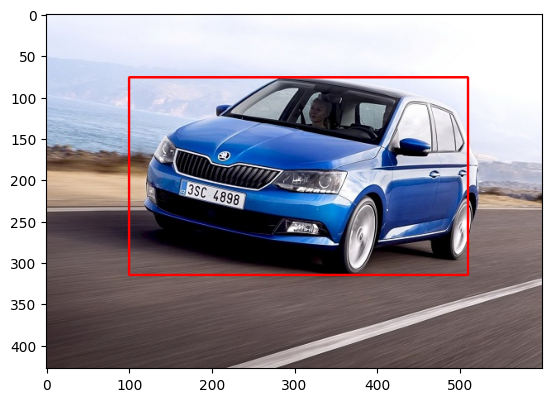

In [134]:
# rozpoznání auta
plt.imshow(img_rect)

print("Barvy auta:", color_name[1])
text = result[0][1]
print("SPZ:", text)